In [1]:
#%tensorflow_version has no effect. 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name !='/device:GPU:0':
  raise SystemError('GPU device not found')
  print ('Found GPU at: {}'.format(device_name))


Для разработки программы предлагается использование языка Python с JIT-компилятором Numba и дополнительным модулем **numba.cuda** для параллельных вычислений на GPU


In [2]:
# Импортируем необходимые библиотеки и модули 

import numpy as np 
import time
from numba import cuda  # Библиотека Nvidia для работы с GPU
import math

import matplotlib.pyplot as plt

Inicialisation of matrixes for CPU

In [3]:
matrix_size = 512

cpu_first_matrix = np.random.randint(0, 5, (matrix_size, matrix_size))                          #np.random.randint(low, high, (row size, column size))
cpu_second_matrix = np.random.randint(0, 5, (matrix_size, matrix_size))
cpu_result_matrix = np.zeros((matrix_size, matrix_size), dtype=int)

Inicialisation of matrixes for GPU

In [4]:
# Перенос с хоста на устройство

gpu_first_matrix = cuda.to_device(cpu_first_matrix)
gpu_second_matrix = cuda.to_device(cpu_second_matrix)
gpu_result_matrix = cuda.device_array((len(cpu_first_matrix), len(cpu_second_matrix)))

In [5]:
# Перемножение матриц на CPU
def cpu_matmul(cpu_first_matrix, cpu_second_matrix, cpu_result_matrix):
    for i in range(matrix_size):
        for j in range(matrix_size):
            result = 0
            for k in range(matrix_size):
                result += cpu_first_matrix[i, k] * cpu_second_matrix[k, j]
            cpu_result_matrix[i, j] = result



#Перемножение матриц на GPU
@cuda.jit                                                                        #Динамический компилятор Cuda 
def gpu_matmul(gpu_first_matrix, gpu_second_matrix, gpu_result_matrix):
    for i in range(matrix_size):
        for j in range(matrix_size):
            result = 0
            for k in range(matrix_size):
                result += gpu_first_matrix[i, k] * gpu_second_matrix[k, j]
            gpu_result_matrix[i, j] = result



def cpu_and_gpu_calc():
    # Количество нитей в блоке
    threads_per_block = (32, 32)

     # Количество блоков на сетку (сетка двумерная, т.к. массив двумерный)
    blocks_per_grid_x = int(math.ceil(cpu_first_matrix.shape[0] / threads_per_block[0]))                                   # shape[0] then it will gave you the number of rows
    blocks_per_grid_y = int(math.ceil(cpu_second_matrix.shape[1] / threads_per_block[1]))
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)
    print("Размер сетки = ", blocks_per_grid, threads_per_block)


    print("CPU старт")
    start_time = time.time()
    cpu_matmul(cpu_first_matrix, cpu_second_matrix, cpu_result_matrix)
    stop_time = time.time()
    print("CPU стоп,  потрачено  %s секунд" % (stop_time - start_time))

    print("GPU старт")
    start_time = time.time()
    gpu_matmul[blocks_per_grid, threads_per_block](gpu_first_matrix, gpu_second_matrix, gpu_result_matrix)
    stop_time = time.time()
    print("GPU стоп,  потрачено  %s секунд" % (stop_time - start_time))

In [6]:
if __name__ == "__main__":
    cpu_and_gpu_calc()

Размер сетки =  (16, 16) (32, 32)
CPU старт
CPU стоп,  потрачено  56.15344595909119 секунд
GPU старт
GPU стоп,  потрачено  0.4952216148376465 секунд


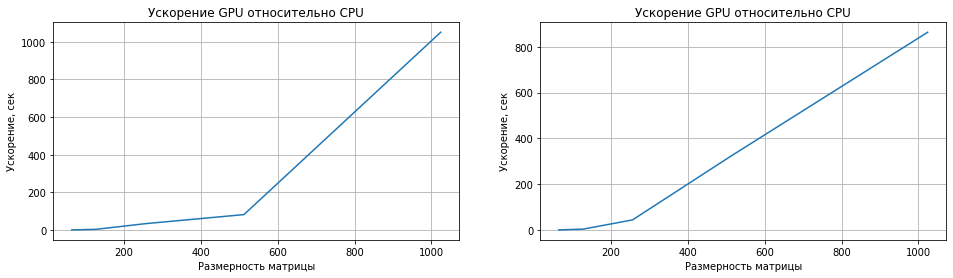

In [7]:
fig, axes = plt.subplots(1, 2, figsize = (16, 4))

axes[0].set_title('Ускорение GPU относительно CPU')
axes[0].set_xlabel('Размерность матрицы')
axes[0].set_ylabel('Ускорение, сек')
x = np.array([64, 128, 256, 512, 1024])
cpu_cal_with_8_threads = np.array([0.20825, 1.08374, 6.07935, 65.99765, 514.44881])
gpu_cal_with_8_threads = np.array([1.89056, 0.31251, 0.18178, 0.80997, 0.48972])
axes[0].plot(x, cpu_cal_with_8_threads/gpu_cal_with_8_threads)                                                          
axes[0].grid()

axes[1].set_title('Ускорение GPU относительно CPU')
axes[1].set_xlabel('Размерность матрицы')
axes[1].set_ylabel('Ускорение, сек')
x = np.array([64, 128, 256, 512, 1024])
cpu_cal_with_32_threads = np.array([0.11322, 0.77603, 7.69036, 56.53427, 472.53074])
gpu_cal_with_32_threads = np.array([0.17093, 0.18270, 0.17323, 0.17511, 0.54704])
axes[1].plot(x, cpu_cal_with_32_threads/gpu_cal_with_32_threads)                                                          
axes[1].grid()

plt.show()